# Business Problem

Is it possible to conduct a machine learning project to predict the salaries of baseball players based on salary information and career statistics from 1986?

# Dataset Story

This dataset was originally obtained from the StatLib library at Carnegie Mellon University.
The salary data was originally from Sports Illustrated, dated April 20, 1987.
The 1986 and career statistics were obtained from the 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

## Dataset Columns

- **AtBat**: Number of times at bat during the 1986-1987 seasons
- **Hits**: Number of hits during the 1986-1987 seasons
- **HmRun**: Number of home runs during the 1986-1987 seasons
- **Runs**: Number of runs during the 1986-1987 seasons
- **RBI**: Number of runs batted in during the 1986-1987 seasons
- **Walks**: Number of walks during the 1986-1987 seasons
- **Years**: Number of years the player has played in the major leagues
- **CAtBat**: Number of times at bat during the player's career
- **CHits**: Number of hits during the player's career
- **CHmRun**: Number of home runs during the player's career
- **CRuns**: Number of runs during the player's career
- **CRBI**: Number of runs batted in during the player's career
- **CWalks**: Number of walks during the player's career
- **League**: A factor indicating the player's league at the end of the season, with levels A and N
- **Division**: A factor indicating the division the player played in at the end of 1986, with levels E and W
- **PutOuts**: Number of put outs during the 1986 season
- **Assists**: Number of assists during the 1986-1987 seasons
- **Errors**: Number of errors during the 1986-1987 seasons
- **Salary**: Player's salary for the 1986-1987 seasons (in thousands)
- **NewLeague**: A factor indicating the player's league at the beginning of the 1987 season, with levels A and N


## 1. Required Libraries and Functions

In [1]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


## 2. Advanced Functional EDA

In [2]:
df = pd.read_csv("hitters.csv")

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### Head #####################")
    print(dataframe.head(head))

    print("##################### Tail #####################")
    print(dataframe.tail(head))

    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    print("##################### Quantiles #####################")
    print(dataframe.describe().T)

check_df(df)


##################### Shape #####################
(322, 20)
##################### Types #####################
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object
##################### Head #####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    32

In [3]:
##################################################
# Capturing numerical and Ccategorical variables 
##################################################

def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [4]:
cat_cols

['League', 'Division', 'NewLeague']

        League  Ratio
League               
A          175 54.348
N          147 45.652
##########################################


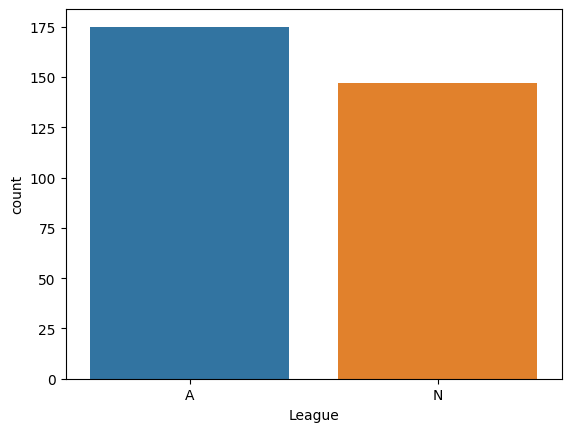

          Division  Ratio
Division                 
W              165 51.242
E              157 48.758
##########################################


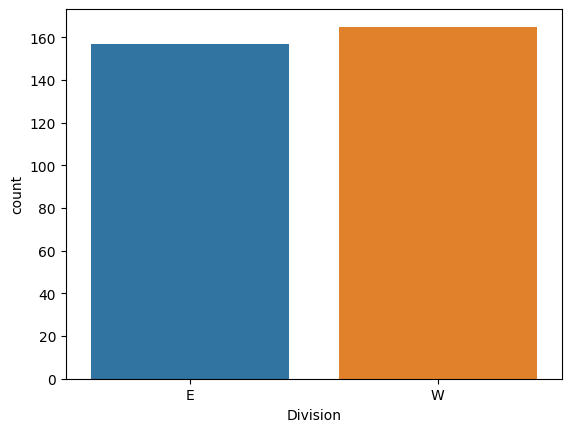

           NewLeague  Ratio
NewLeague                  
A                176 54.658
N                146 45.342
##########################################


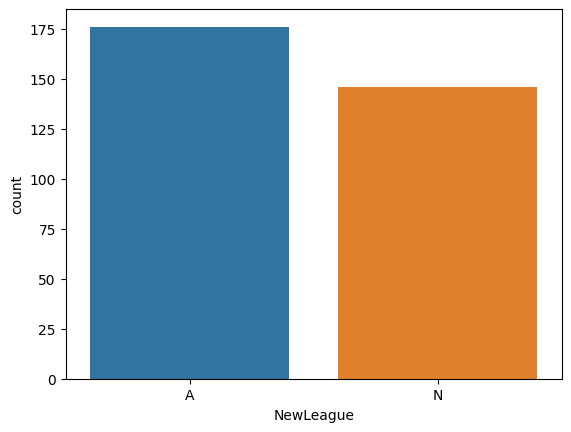

In [5]:
#########################################
# Analysis of Categorical Variables
#########################################

def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col, plot=True)

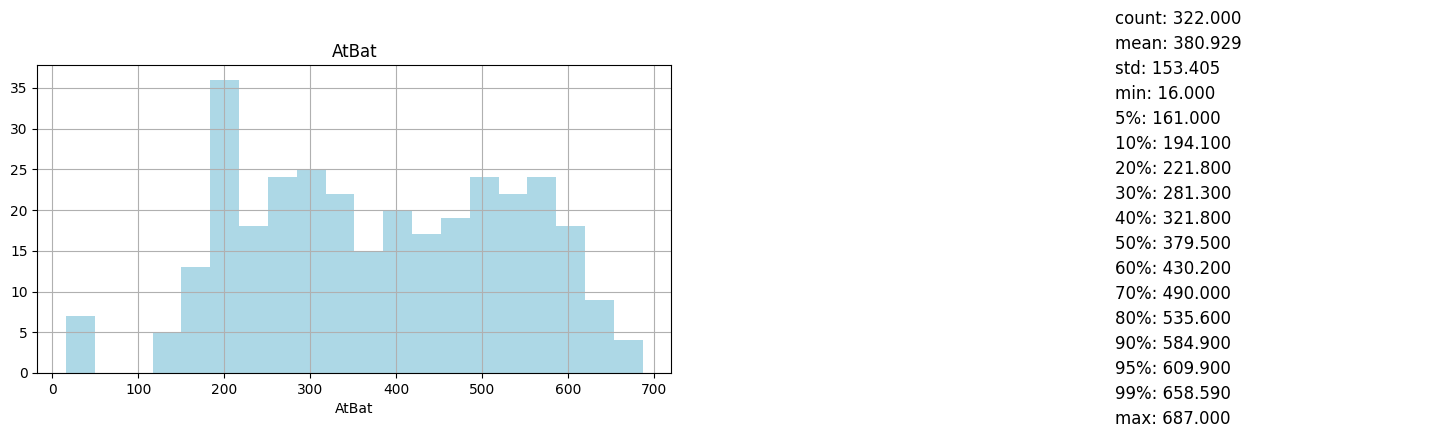

################################################################


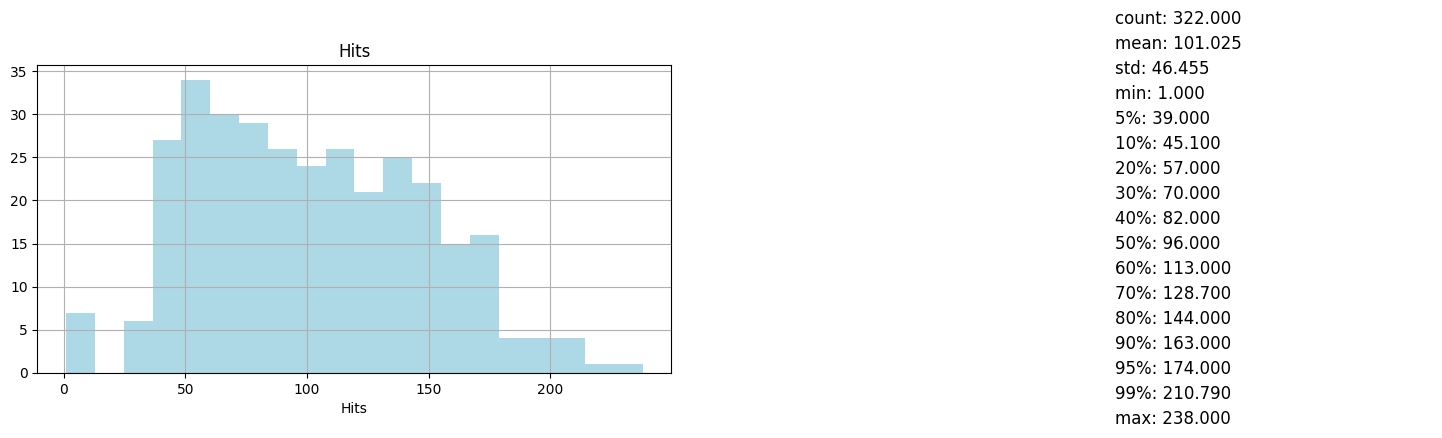

################################################################


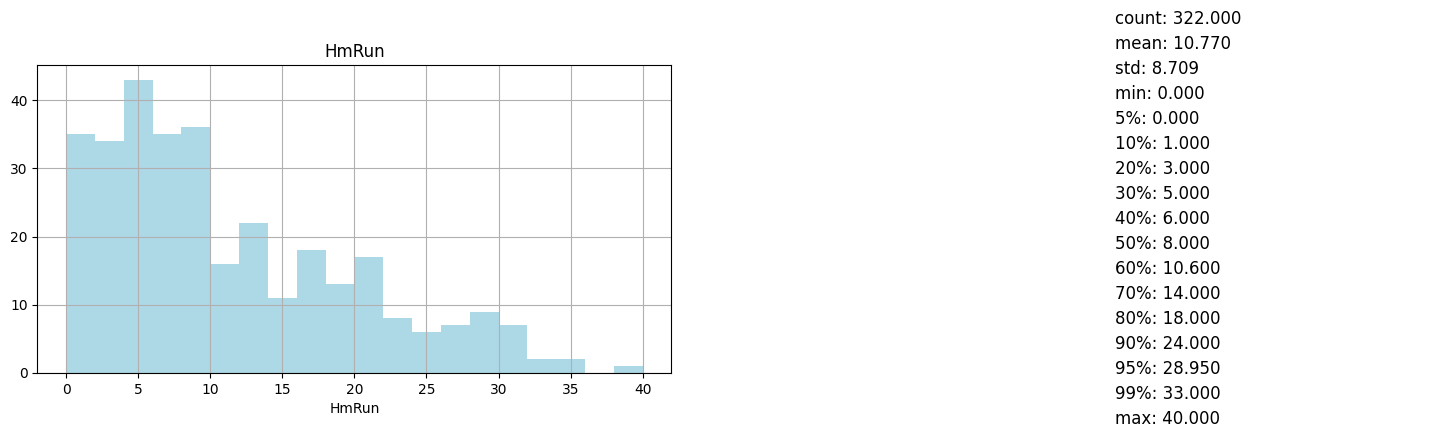

################################################################


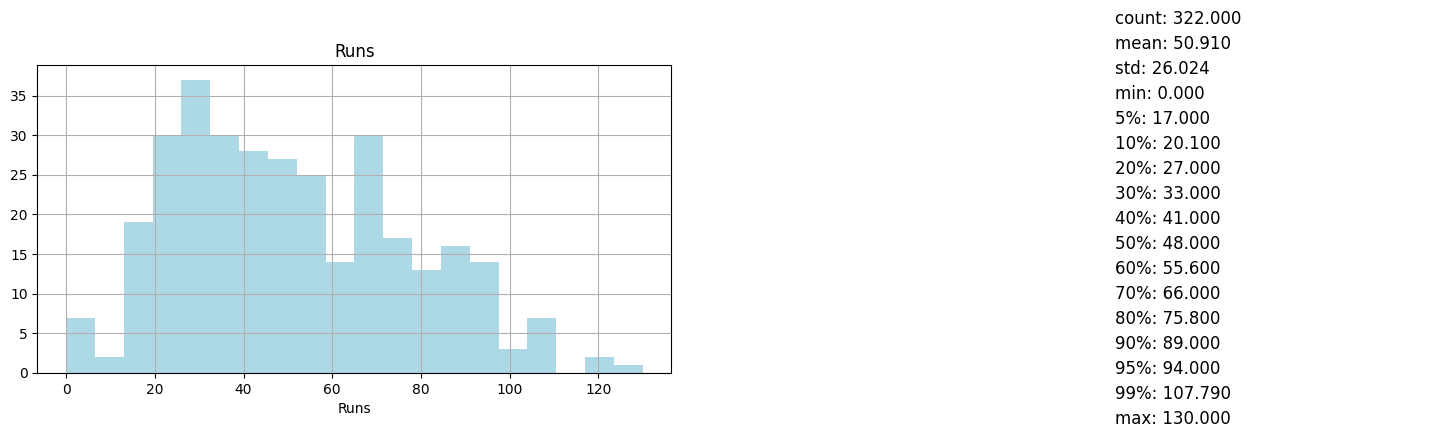

################################################################


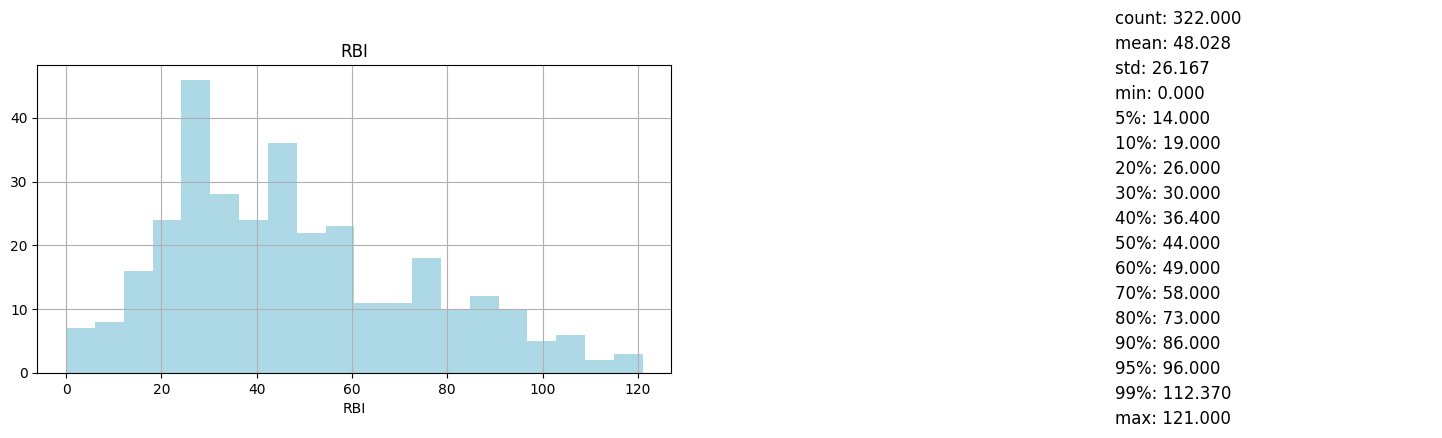

################################################################


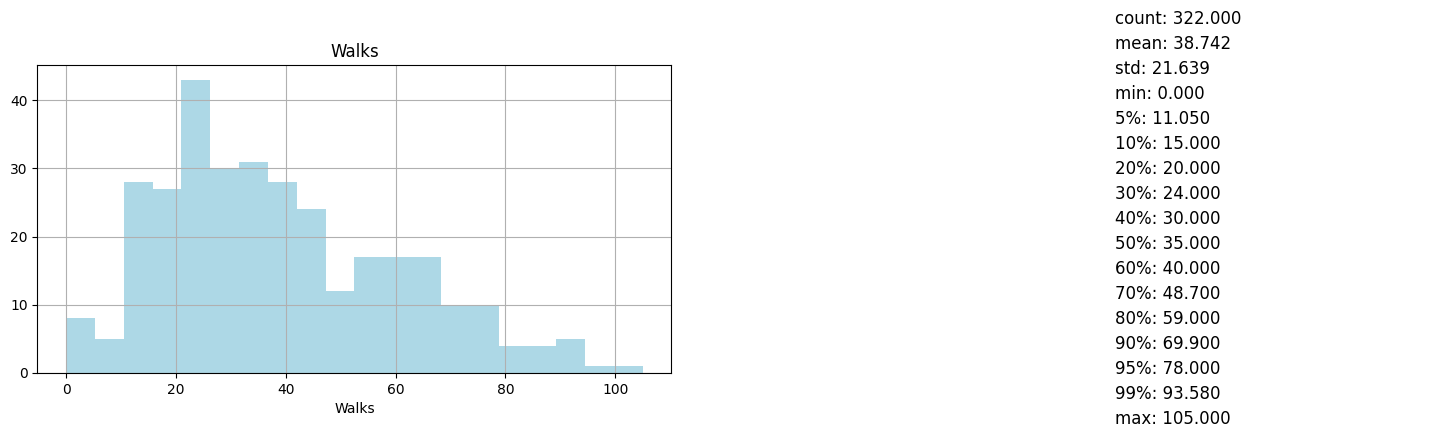

################################################################


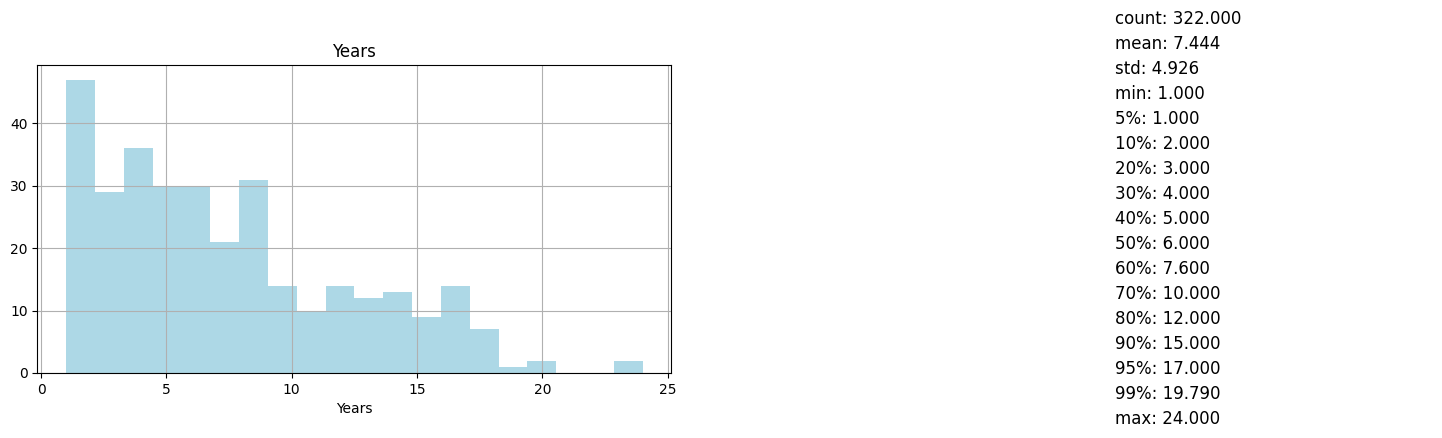

################################################################


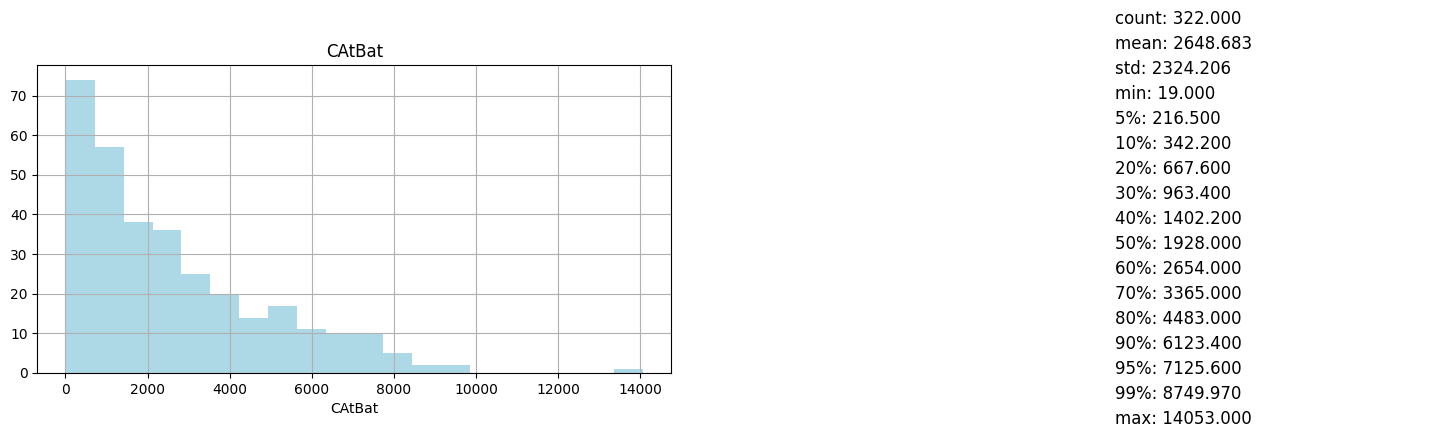

################################################################


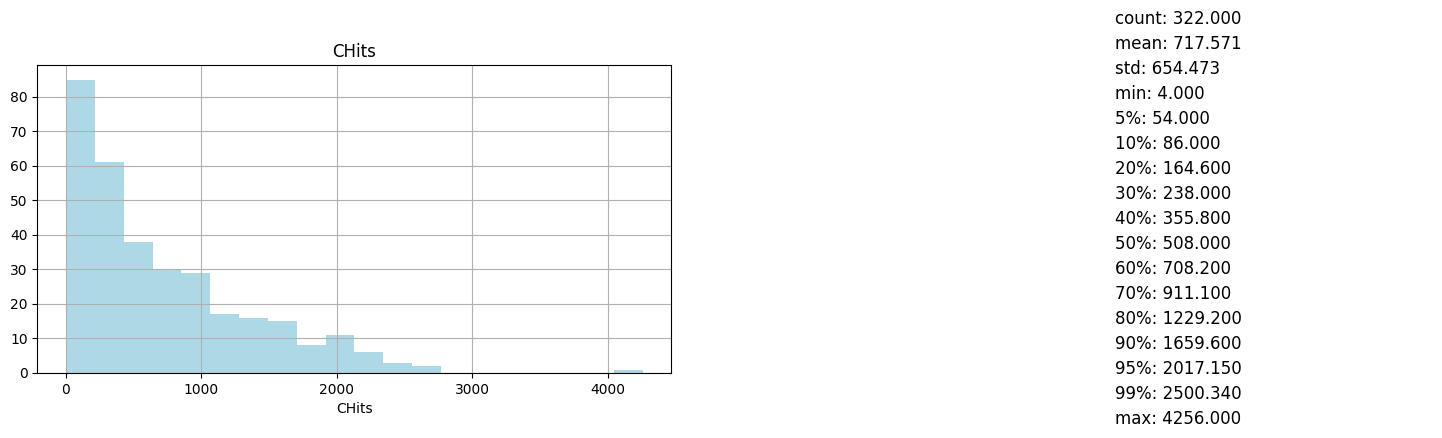

################################################################


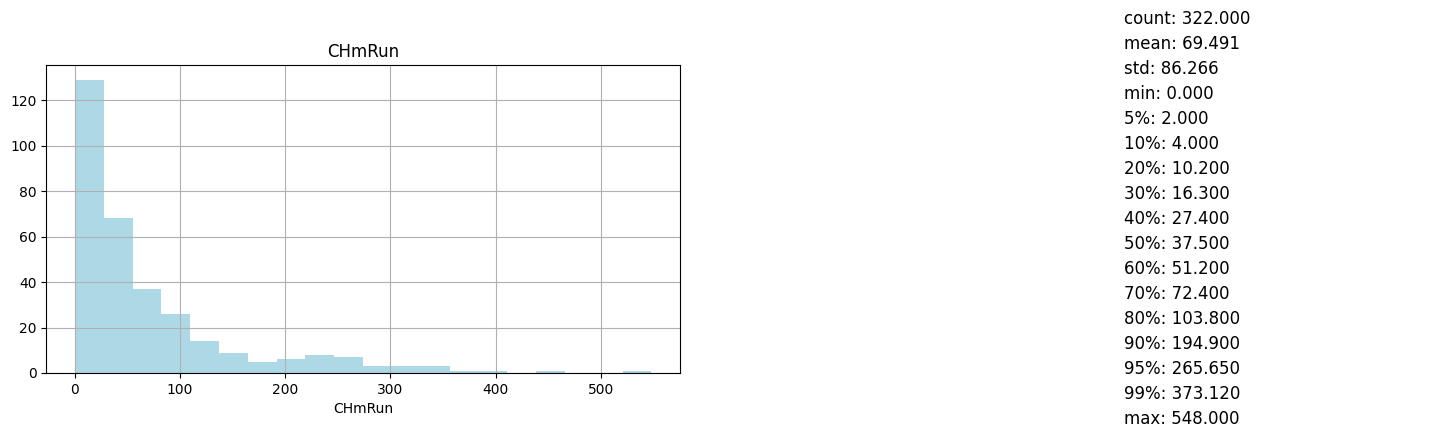

################################################################


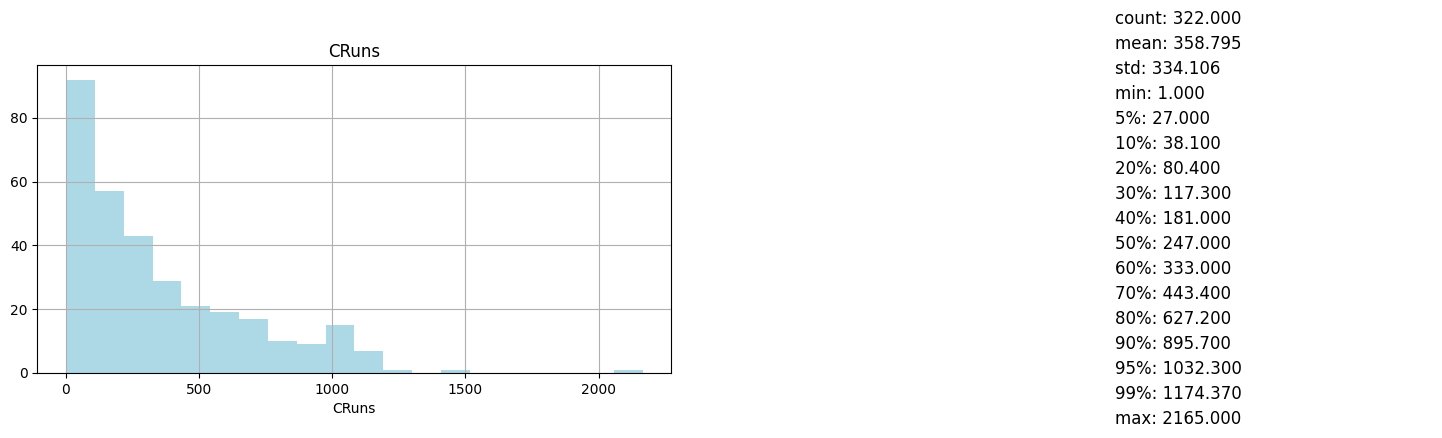

################################################################


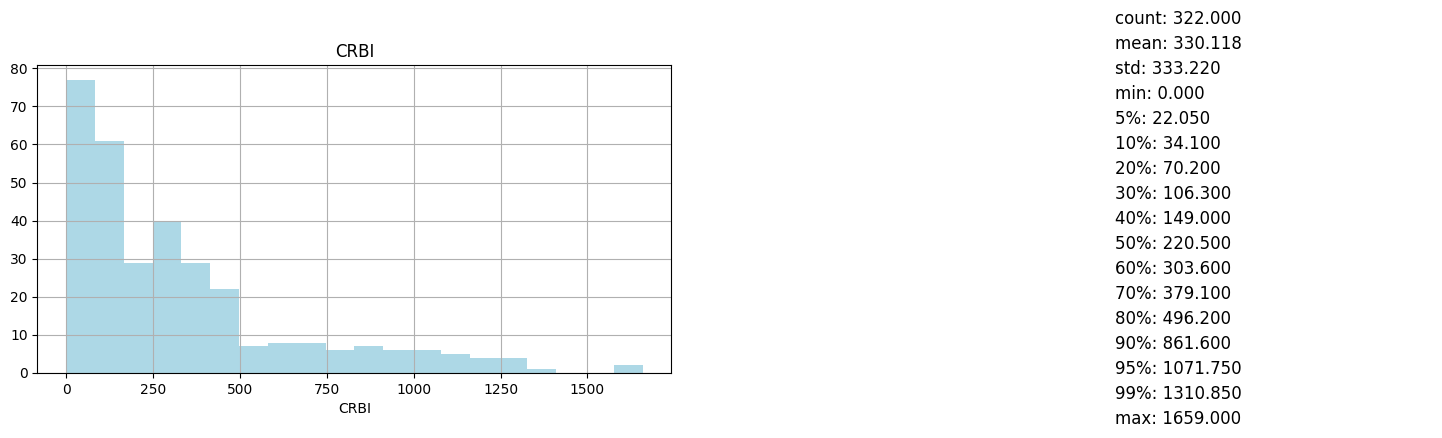

################################################################


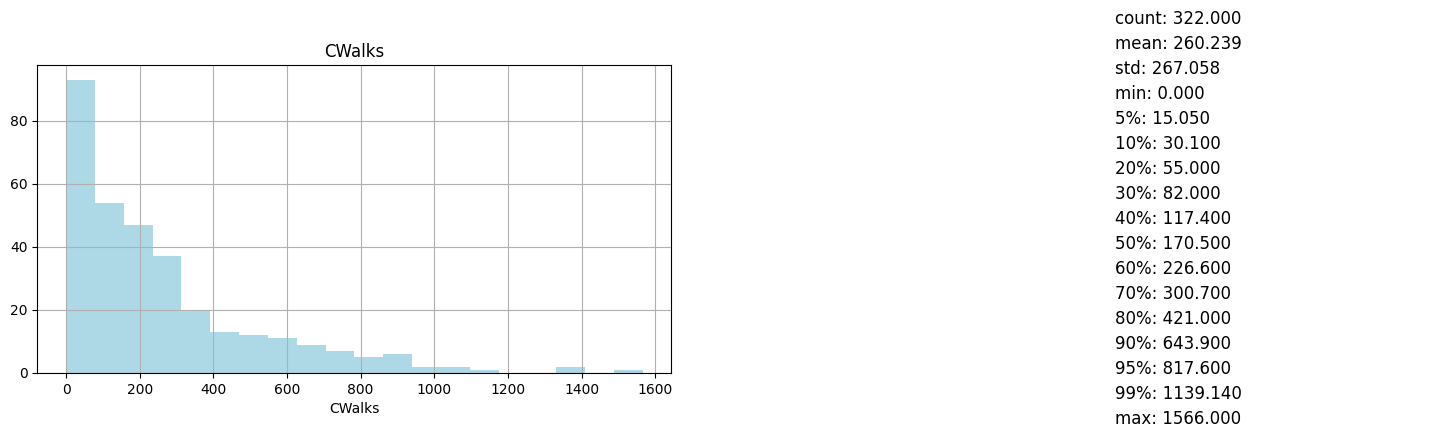

################################################################


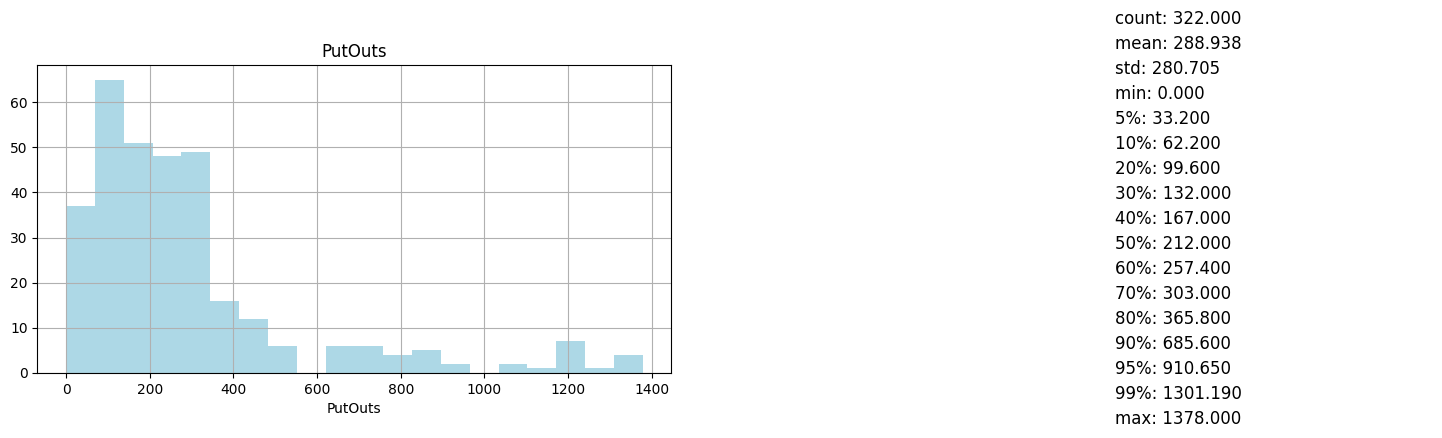

################################################################


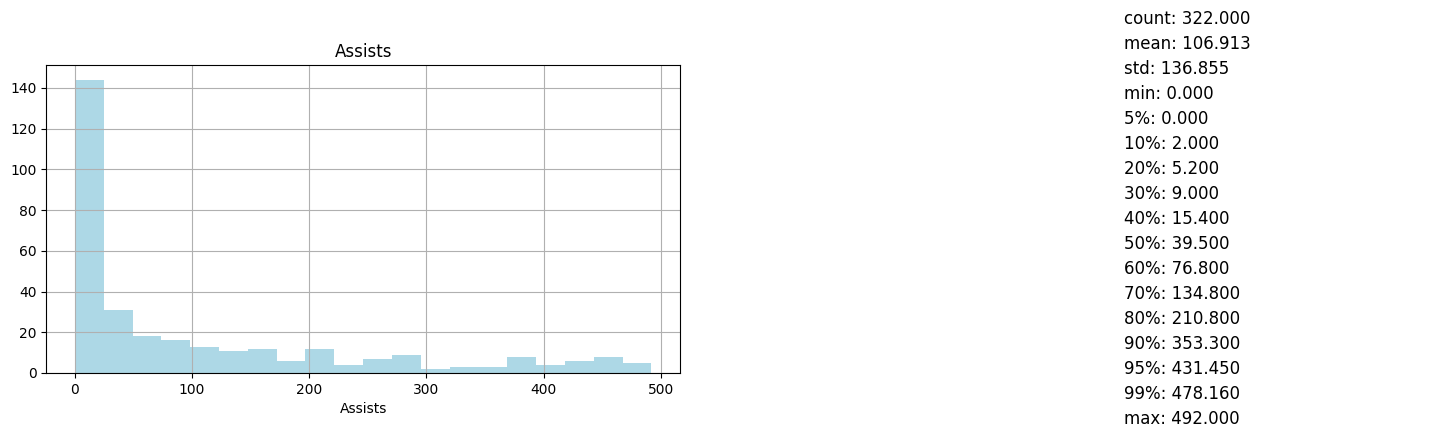

################################################################


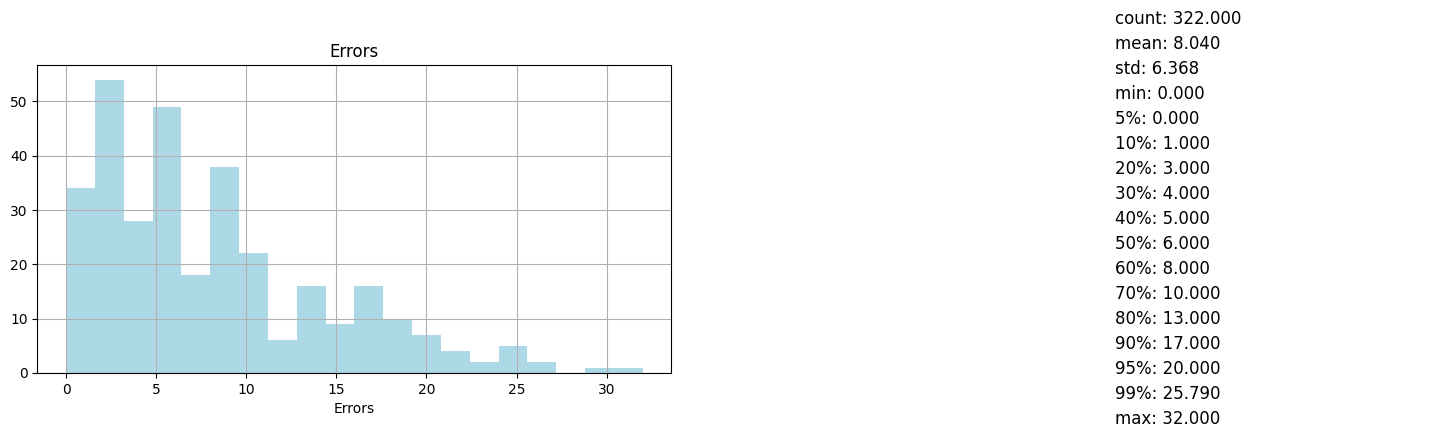

################################################################


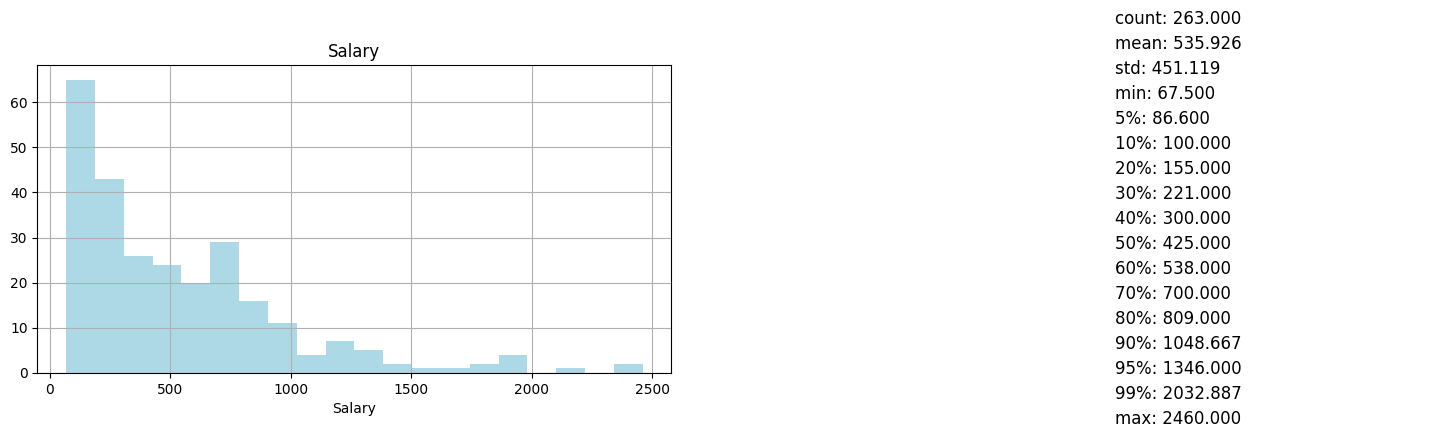

################################################################


In [6]:
########################################
# Analysis of Numerical Variables
########################################

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    summary = dataframe[numerical_col].describe(quantiles)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(18, 4))
        
        # Plot histogram
        dataframe[numerical_col].hist(bins=20, ax=axes[0], color="lightblue")
        axes[0].set_xlabel(numerical_col)
        axes[0].set_title(numerical_col)
        
        # Displaying summary statistics as text
        summary_text = "\n".join([f'{col}: {value:.3f}' for col, value in summary.items()])
        axes[1].text(0.5, 0.5, summary_text, fontsize=12, va='center', ha='left', linespacing=1.5)
        axes[1].axis('off')  
        
        plt.show()
        print("################################################################")

for col in num_cols:
    num_summary(df, col, plot=True) 

In [7]:
#####################################
# Analysis of Target Variable
#####################################

def target_summary_with_cat(dataframe, target, categorical_col):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Salary", col)

        TARGET_MEAN
League             
A           542.000
N           529.118


          TARGET_MEAN
Division             
E             624.271
W             450.877


           TARGET_MEAN
NewLeague             
A              537.113
N              534.554




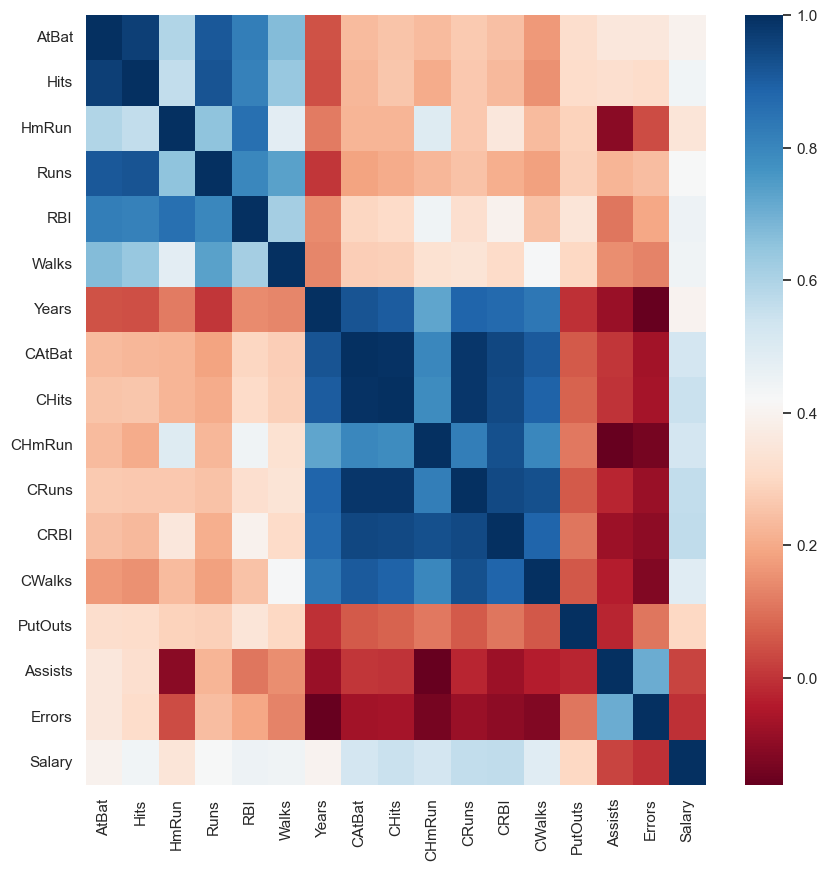

['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

In [8]:
##################################
# Analysis of Correlation
##################################

def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    # Select only numeric columns
    numeric_cols = dataframe.select_dtypes(include=['number'])
    
    corr = numeric_cols.corr()
    cor_matrix = corr.abs()
    
    # Create a mask to exclude the upper triangle of the correlation matrix
    mask = np.triu(np.ones(cor_matrix.shape), k=1).astype(bool)  # Replace np.bool with bool
    
    # Create a masked correlation matrix
    upper_triangle_matrix = cor_matrix.where(mask)
    
    # Find columns with correlations above the threshold
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (10, 10)})  # Adjust the figsize here (e.g., (8, 8))
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    
    return drop_list

high_correlated_cols(df, plot=True)




## 3. Feature Engineering

In [9]:
################
# Outliers 
################

def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [10]:
for col in num_cols:
    print(col, check_outlier(df, col))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits True
CHmRun True
CRuns False
CRBI False
CWalks True
PutOuts False
Assists False
Errors False
Salary False


In [11]:
for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

In [12]:
########################
# Missing Values
########################

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

missing_values_table(df)

        n_miss  ratio
Salary      59 18.320


In [13]:
df.dropna(inplace=True)

In [14]:
############################
# Feature Extraction
############################

new_num_cols=[col for col in num_cols if col!="Salary"]

df[new_num_cols]=df[new_num_cols]+0.0000000001

df['NEW_Hits'] = df['Hits'] / df['CHits'] + df['Hits']
df['NEW_RBI'] = df['RBI'] / df['CRBI']
df['NEW_Walks'] = df['Walks'] / df['CWalks']
df['NEW_PutOuts'] = df['PutOuts'] * df['Years']
df["Hits_Success"] = (df["Hits"] / df["AtBat"]) * 100
df["NEW_CRBI*CATBAT"] = df['CRBI'] * df['CAtBat']
df["NEW_RBI"] = df["RBI"] / df["CRBI"]
df["NEW_Chits"] = df["CHits"] / df["Years"]
df["NEW_CHmRun"] = df["CHmRun"] * df["Years"]
df["NEW_CRuns"] = df["CRuns"] / df["Years"]
df["NEW_Chits"] = df["CHits"] * df["Years"]

In [15]:
############################
# One-Hot Encoding
############################

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,League_N,Division_W,NewLeague_N
1,315.000,81.000,7.000,24.000,38.000,39.000,14.000,3449.000,835.000,69.000,321.000,414.000,375.000,632.000,43.000,10.000,475.000,81.097,0.092,0.104,8848.000,25.714,1427886.000,11690.000,966.000,22.929,True,True,True
2,479.000,130.000,18.000,66.000,72.000,76.000,3.000,1624.000,457.000,63.000,224.000,266.000,263.000,880.000,82.000,14.000,480.000,130.284,0.271,0.289,2640.000,27.140,431984.000,1371.000,189.000,74.667,False,True,False
3,496.000,141.000,20.000,65.000,78.000,37.000,11.000,5628.000,1575.000,225.000,828.000,838.000,354.000,200.000,11.000,3.000,500.000,141.090,0.093,0.105,2200.000,28.427,4716264.000,17325.000,2475.000,75.273,True,False,True
4,321.000,87.000,10.000,39.000,42.000,30.000,2.000,396.000,101.000,12.000,48.000,46.000,33.000,805.000,40.000,4.000,91.500,87.861,0.913,0.909,1610.000,27.103,18216.000,202.000,24.000,24.000,True,False,True
5,594.000,169.000,4.000,74.000,51.000,35.000,11.000,4408.000,1133.000,19.000,501.000,336.000,194.000,282.000,421.000,25.000,750.000,169.149,0.152,0.180,3102.000,28.451,1481088.000,12463.000,209.000,45.545,False,True,False


In [16]:
df.replace({False: 0, True: 1}, inplace=True) 

In [17]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 263
Variables: 29
cat_cols: 3
num_cols: 26
cat_but_car: 0
num_but_cat: 3


In [18]:
#########################
# Feature Scaling
#########################

num_cols = [col for col in num_cols if col not in ["Salary"]]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,League_N,Division_W,NewLeague_N
1,-0.603,-0.596,-0.529,-1.206,-0.522,-0.098,1.398,0.347,0.177,0.000,-0.122,0.259,0.435,1.221,-0.523,0.213,475.000,-0.601,-0.830,-0.787,2.322,-0.168,-0.056,0.314,0.135,-1.060,1,1,1
2,0.513,0.492,0.730,0.442,0.794,1.609,-0.901,-0.453,-0.412,-0.074,-0.415,-0.200,0.010,2.109,-0.254,0.820,480.000,0.492,-0.226,-0.145,0.186,0.277,-0.425,-0.573,-0.444,1.393,0,1,0
3,0.628,0.736,0.959,0.402,1.026,-0.190,0.771,1.302,1.329,1.934,1.412,1.573,0.356,-0.325,-0.744,-0.848,500.000,0.732,-0.825,-0.785,0.035,0.679,1.163,0.798,1.258,1.422,1,0,1
4,-0.562,-0.462,-0.185,-0.618,-0.367,-0.513,-1.110,-0.991,-0.966,-0.707,-0.948,-0.881,-0.862,1.841,-0.544,-0.697,91.500,-0.451,1.941,2.005,-0.168,0.265,-0.578,-0.673,-0.566,-1.009,1,0,1
5,1.295,1.358,-0.872,0.755,-0.019,-0.282,0.771,0.767,0.641,-0.620,0.423,0.017,-0.251,-0.031,2.087,2.488,750.000,1.355,-0.627,-0.522,0.345,0.686,-0.036,0.380,-0.429,0.012,0,1,0


In [19]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,League_N,Division_W,NewLeague_N
1,-0.603,-0.596,-0.529,-1.206,-0.522,-0.098,1.398,0.347,0.177,0.000,-0.122,0.259,0.435,1.221,-0.523,0.213,475.000,-0.601,-0.830,-0.787,2.322,-0.168,-0.056,0.314,0.135,-1.060,1,1,1
2,0.513,0.492,0.730,0.442,0.794,1.609,-0.901,-0.453,-0.412,-0.074,-0.415,-0.200,0.010,2.109,-0.254,0.820,480.000,0.492,-0.226,-0.145,0.186,0.277,-0.425,-0.573,-0.444,1.393,0,1,0
3,0.628,0.736,0.959,0.402,1.026,-0.190,0.771,1.302,1.329,1.934,1.412,1.573,0.356,-0.325,-0.744,-0.848,500.000,0.732,-0.825,-0.785,0.035,0.679,1.163,0.798,1.258,1.422,1,0,1
4,-0.562,-0.462,-0.185,-0.618,-0.367,-0.513,-1.110,-0.991,-0.966,-0.707,-0.948,-0.881,-0.862,1.841,-0.544,-0.697,91.500,-0.451,1.941,2.005,-0.168,0.265,-0.578,-0.673,-0.566,-1.009,1,0,1
5,1.295,1.358,-0.872,0.755,-0.019,-0.282,0.771,0.767,0.641,-0.620,0.423,0.017,-0.251,-0.031,2.087,2.488,750.000,1.355,-0.627,-0.522,0.345,0.686,-0.036,0.380,-0.429,0.012,0,1,0


In [20]:
#############################################
# Base Models
#############################################

y = df["Salary"]
X = df.drop(["Salary"], axis=1)

models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]


for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 272.4232 (LR) 
RMSE: 263.1289 (Ridge) 
RMSE: 270.6549 (Lasso) 
RMSE: 306.4974 (ElasticNet) 
RMSE: 295.8103 (KNN) 
RMSE: 379.9498 (CART) 
RMSE: 263.2276 (RF) 
RMSE: 441.2692 (SVR) 
RMSE: 258.5146 (GBM) 
RMSE: 271.7846 (XGBoost) 
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1675
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 28
[LightGBM] [Info] Start training from score 543.442220
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

C:\Users\Murat Kiran\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Murat Kiran\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Anaconda\envs\ml_env\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Anaconda\envs\ml_env\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Anaconda\envs\ml_env\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 237, number of used features: 28
[LightGBM] [Info] Start training from score 539.801717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

RMSE: 272.4232 (LR)

RMSE: 263.1289 (Ridge) 

RMSE: 270.6549 (Lasso) 

RMSE: 306.4974 (ElasticNet)

RMSE: 295.8103 (KNN) 

RMSE: 379.9498 (CART) 

RMSE: 263.2276 (RF) 

RMSE: 441.2692 (SVR) 

RMSE: 258.5146 (GBM) 

RMSE: 271.7846 (XGBoost)

RMSE: 280.9673 (LightGBM) 

RMSE: 260.5912 (CatBoost) 

In [21]:
################################################
# Random Forests
################################################

rf_model = RandomForestRegressor(random_state=17)

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(rf_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Anaconda\envs\ml_env\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
112 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Anaconda\envs\ml_env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\envs\ml_env\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Anaconda\envs\ml_env\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Anaconda\envs\ml_env\lib\site-packages\sk

262.00698937290423

262.00698937290423

In [22]:
################################################
# GBM Model
################################################

gbm_model = GradientBoostingRegressor(random_state=17)

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(gbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 24 candidates, totalling 120 fits


253.8984244916699

In [23]:
################################################
# LightGBM
################################################

lgbm_model = LGBMRegressor(random_state=17)

lgbm_params = {"learning_rate": [0.01, 0.1],
                "n_estimators": [300, 500],
                "colsample_bytree": [0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 263, number of used features: 28
[LightGBM] [Info] Start training from score 535.925882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1675
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 28
[LightGBM] [Info] Start training from score 543.442220
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 28
[LightGBM] [Info] Start training from score 545.781102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1671
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 28
[LightGBM] [Info] Start training from score 512.989606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 237, number of used features: 28
[LightGBM] [Info] Start training from score 530.356975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1691
[LightGBM] [Info] Number of data points in the train set: 237, number of used features: 28
[LightGBM] [Info] Start training from score 538.401578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1682
[LightGBM] [Info] Number of data points in the train set: 237, number of used features: 28
[LightGBM] [Info] Start training from score 528.372743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

277.1100640313187

In [24]:
################################################
# CatBoost
################################################

catboost_model = CatBoostRegressor(random_state=17, verbose=False)

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)
rmse = np.mean(np.sqrt(-cross_val_score(catboost_final, X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

Fitting 5 folds for each of 8 candidates, totalling 40 fits


259.26552737347225

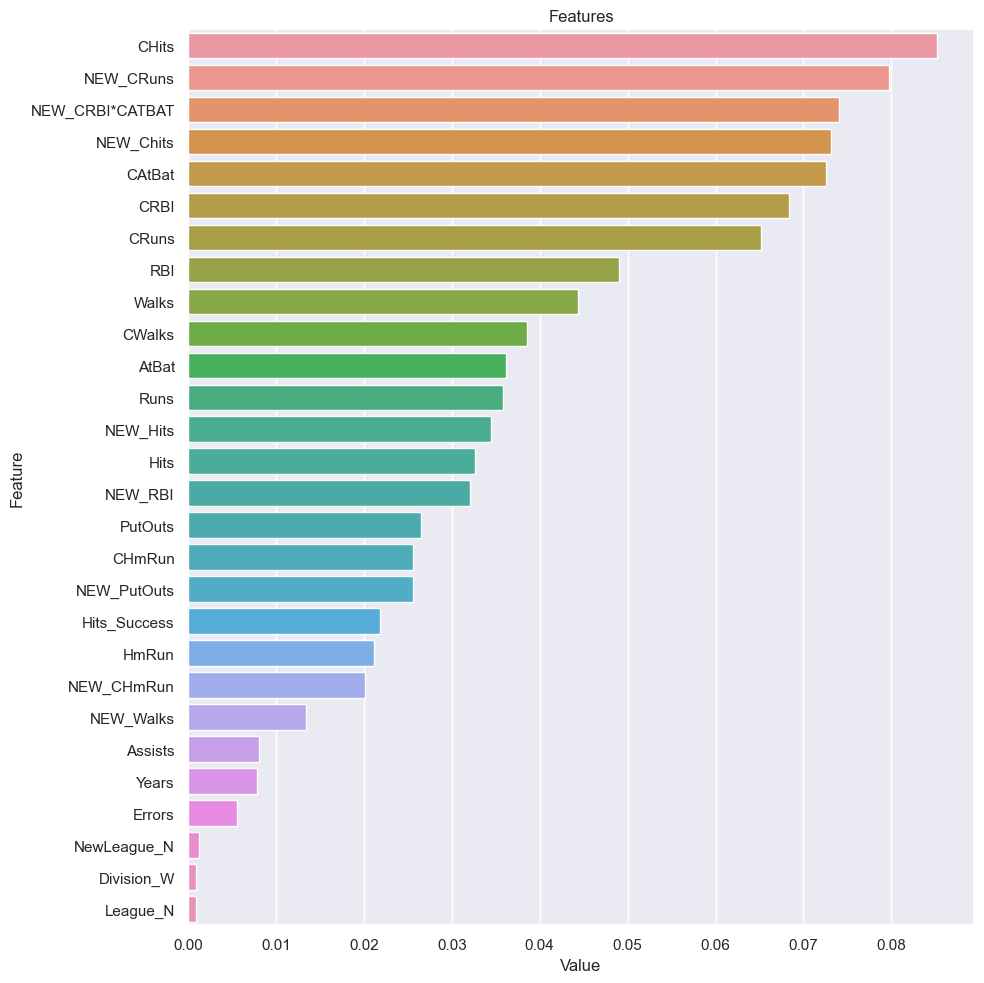

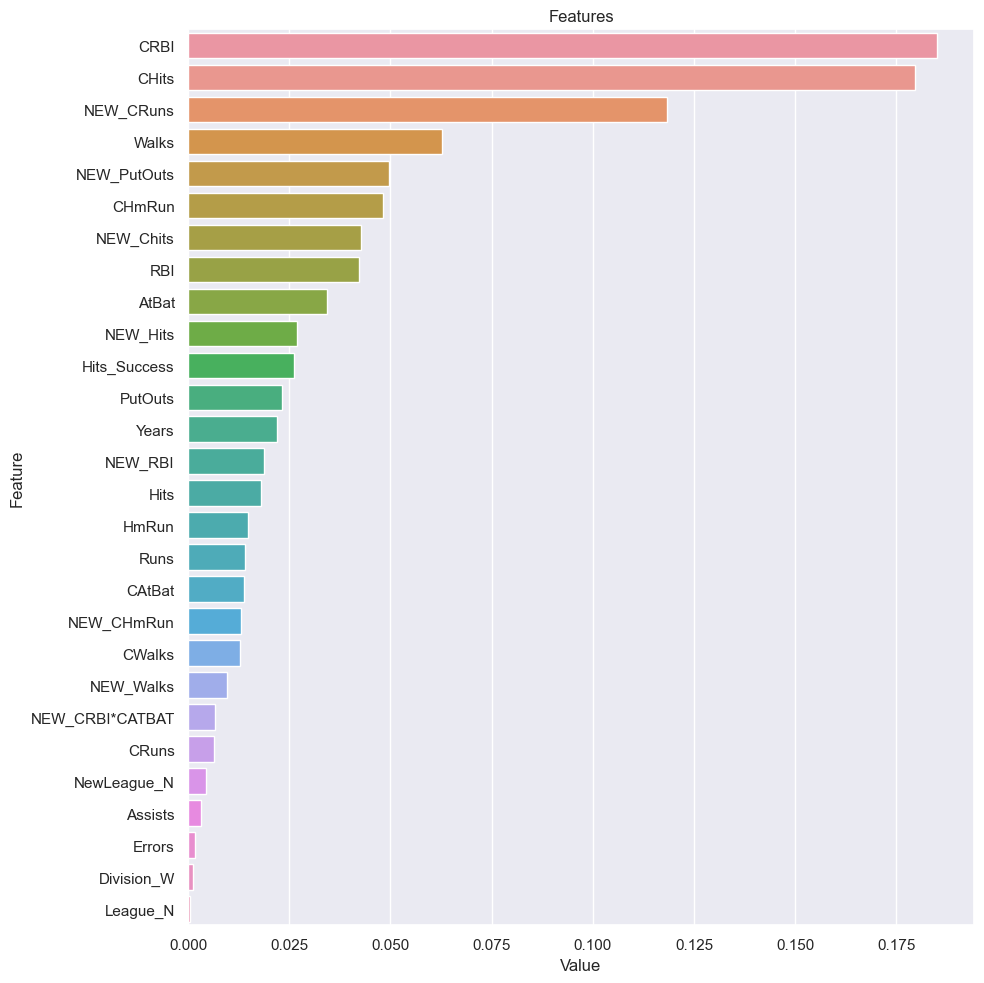

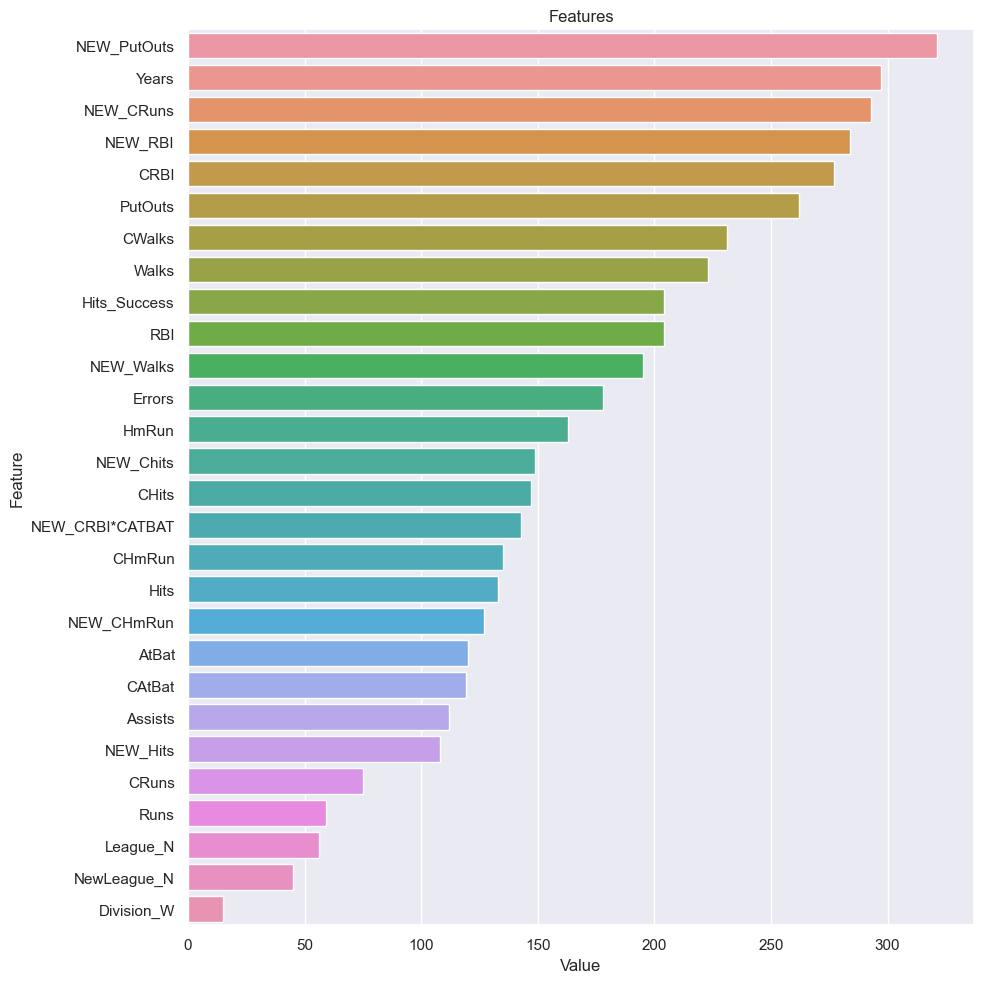

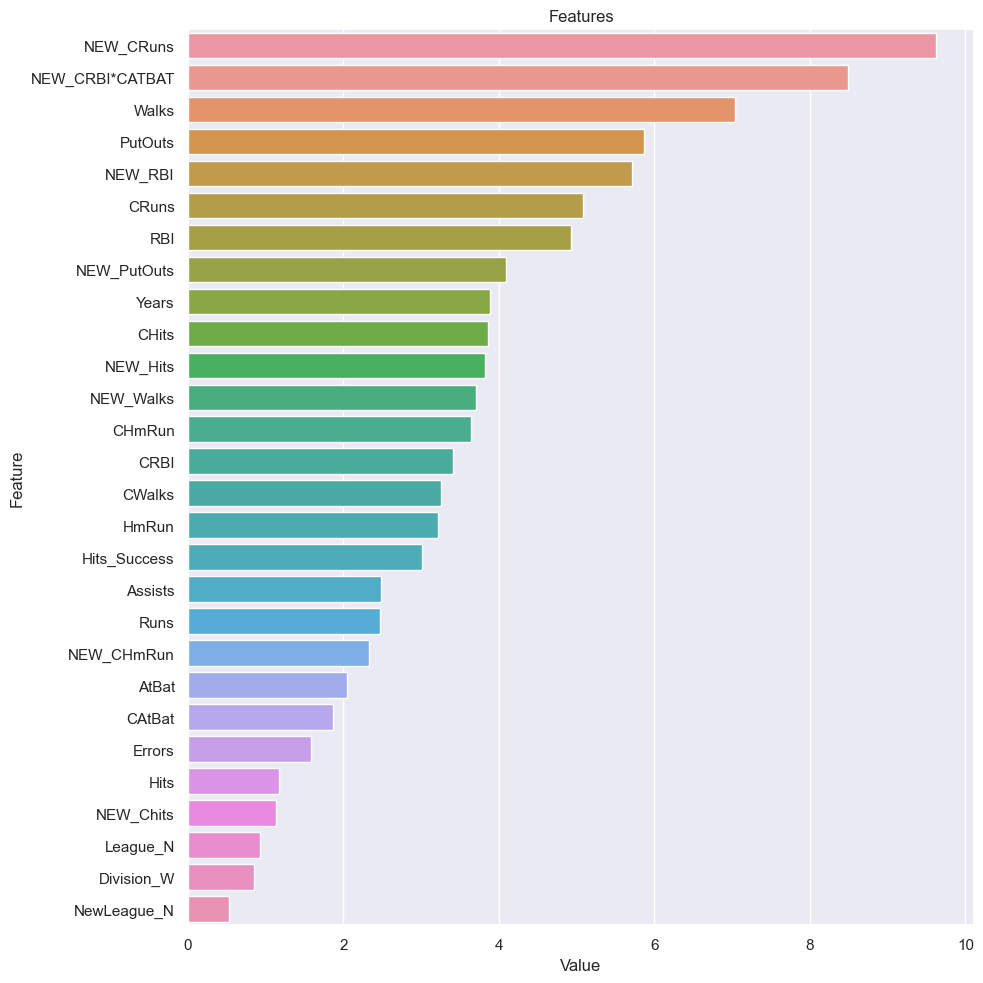

In [26]:
################################################
# Feature Importance
################################################

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_final, X)
plot_importance(gbm_final, X)
plot_importance(lgbm_final, X)
plot_importance(catboost_final, X)